In [1]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features 

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()  
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [3]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2650.9,539.9,1434.0,502.4,3.9,2.0
std,2.1,2.0,12.6,2166.9,419.3,1141.9,383.0,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1464.0,298.0,795.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2141.0,435.0,1167.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3154.2,647.0,1719.0,607.0,4.8,2.3
max,42.0,-114.5,52.0,30401.0,4957.0,35682.0,4769.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.4,2626.4,538.3,1419.0,498.3,3.9,2.0
std,2.1,2.0,12.6,2211.0,426.8,1162.1,388.1,1.9,1.0
min,32.6,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.7,18.0,1455.8,294.0,779.0,278.0,2.6,1.5
50%,34.2,-118.5,28.0,2105.0,429.0,1166.0,404.0,3.5,1.9
75%,37.7,-118.0,37.0,3146.2,654.2,1727.0,601.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,27.1


Training targets summary:


,median_house_value
count,12000.0
mean,207.7
std,116.2
min,15.0
25%,119.6
50%,180.5
75%,265.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.4
std,115.5
min,15.0
25%,119.2
50%,179.9
75%,262.8
max,500.0


In [4]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           

    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [23]:
def train_model(
    learning_rate,
    steps, 
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    my_optimizer = partial(optimizers.Ftrl, learning_rate=learning_rate, clipnorm=5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    
    training_rmse = []
    validation_rmse = []
    
    for period in range (0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        print("  period %d : %f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (on training data):
  period 0 : 230.271034
  period 1 : 150.953540
  period 2 : 126.815248
  period 3 : 116.915625
  period 4 : 113.933073
  period 5 : 107.791551
  period 6 : 206.418603
  period 7 : 196.505850
  period 8 : 188.422339
  period 9 : 181.686984
Model training finished.


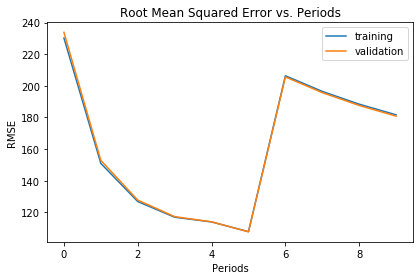

In [12]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## 불연속 특성에 대한 원-핫 인코딩

문자열, 열거형, 정수 등의 불연속 특성은 일반적으로 로지스틱 회귀 모델을 학습하기 전에 이진 특성 패밀리로 변환됩니다.

예를 들어 값으로 `0`, `1`, `2`만 취할 수 있는 합성 특성을 만들었으며 몇 개의 학습 포인트가 있다고 가정해 보겠습니다.

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

가능한 각 범주 값에 대해 **실수값**으로 새 **이진** 특성을 만듭니다. 이 특성은 2가지 값만 취할 수 있는데, 예에 해당 값이 포함되었으면 1.0이고 그렇지 않으면 0.0입니다. 위 예제에서는 범주형 특성을 3개의 특성으로 변환하므로 이제 학습 포인트는 다음과 같습니다.

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

 ## 버킷화(비닝) 특성

버킷화를 비닝이라고도 합니다.

예를 들어 `population`을 다음과 같이 3가지로 버킷화할 수 있습니다.
- `bucket_0` (`< 5000`): 인구가 적은 지역에 해당
- `bucket_1` (`5000 - 25000`): 인구가 중간 정도인 지역에 해당
- `bucket_2` (`> 25000`): 인구가 많은 지역에 해당

이러한 버킷 정의로 다음과 같은 `population` 벡터를 변환할 수 있습니다.

    [[10001], [42004], [2500], [18000]]

버킷화 특성 벡터는 다음과 같습니다.

    [[1], [2], [0], [1]]

특성 값은 이제 버킷 색인입니다. 이러한 색인은 불연속 특성으로 간주됩니다. 이러한 특성은 위와 같이 원-핫 표현으로 변환되는 것이 일반적이지만 이 과정은 투명하게 이루어집니다.

버킷화 특성에 대한 특성 열을 정의하려면 `numeric_column`을 사용하는 대신 [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)을 사용합니다. 이 특성 열은 입력으로 취한 숫자 열을 `boundaries` 인수에 지정된 버킷 경계를 사용하여 버킷화 특성으로 변환합니다. 다음 코드에서는 `households` 및 `longitude`에 대한 버킷화 특성 열을 정의합니다. `get_quantile_based_boundaries` 함수는 분위를 기준으로 경계를 계산하므로 각 버킷은 동일한 수의 요소를 포함합니다.

In [16]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [19]:
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["households"], 7))

longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["longitude"], 10))

In [20]:
def construct_feature_columns():    
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 0 : 168.243305
  period 1 : 142.397612
  period 2 : 126.527911
  period 3 : 115.900138
  period 4 : 108.434794
  period 5 : 102.965302
  period 6 : 98.715292
  period 7 : 95.432801
  period 8 : 92.757088
  period 9 : 90.449414
Model training finished.


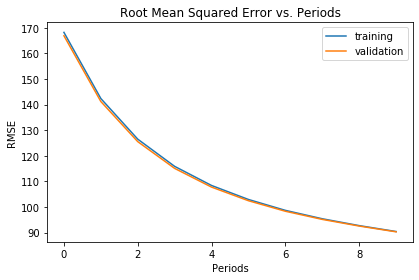

In [24]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [36]:
def construct_feature_columns():
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  bucketized_households = tf.feature_column.bucketized_column(households, boundaries=get_quantile_based_boundaries(training_examples["households"], 7))
  bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries=get_quantile_based_boundaries(training_examples["longitude"], 10))
  bucketized_latitude = tf.feature_column.bucketized_column(latitude, boundaries=get_quantile_based_boundaries(training_examples["latitude"], 10))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(housing_median_age, boundaries=get_quantile_based_boundaries(training_examples["housing_median_age"], 7))
  bucketized_median_income = tf.feature_column.bucketized_column(median_income, boundaries=get_quantile_based_boundaries(training_examples["median_income"], 7))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(rooms_per_person, boundaries=get_quantile_based_boundaries(training_examples["rooms_per_person"], 7))
  
  long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

In [ ]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
